# Use VAEs to compress segmented vaginal microbiome data

Author: Zhengqing Zhou
Updated: 2025/06/13

In this notebook, we first exemplify the training of a VAE model to compress segmented time series of n taxa from vaginal microbiome dataset (Ravel et al. 2013 Microbiome). We then determine the relationship between the FUV and the latent dimension.

In [1]:
# We begin by importing the essentials
import numpy as np
import matplotlib.pyplot as plt

# We also setup torch for later usage.
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import trange
from torch.nn import functional as F
from torch import nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import time as timer
import pickle

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

display(device)

'cuda:0'

# VAE Network
The VAE network has 16 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 14) will not get shortened during the convolutions; and two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):
        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.channels = 16

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )

        self.mean_map = nn.Linear(self.channels * 14, self.latent_dim)

        self.std_map = nn.Linear(self.channels * 14, self.latent_dim)

        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels * 14),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var


def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."

    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha * KLD

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## define utility functions
- load the data
- train, test the model

In [4]:
def get_data(n_target,test_idx):
    arr = np.arange(1,25,1)
    excluded = np.array([test_idx])
    train_arr = np.setdiff1d(arr, excluded)
    X_train = []
    for i in train_arr:
        sub = np.load("./vaginal_dataset_CV/S%i_T%i.npy" % (i, n_target))
        X_train.append(sub)
    X_train = np.vstack(X_train)
    X_test = np.load("./vaginal_dataset_CV/S%i_T%i.npy" % (test_idx, n_target))
    return X_train, X_test

In [5]:
def train_model(model, data_loader, optimizer, device = "cuda:0"):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for batch in data_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred, code, mu, log_var = model(batch)
        loss = vae_loss(pred, batch, mu, log_var)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader, device = "cuda:0"):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            pred, code, mu, log_var = model(batch)
            loss = vae_loss(pred, batch, mu, log_var)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

# Example: training a single VAE model on the relative abundance data

In [6]:
n_target = 1
test_idx = 5
n_embedding = 8
lr = 5e-4
lr_decay = 0.95
batch_size = 64
EPOCHS = 30

X_train, X_test = get_data(n_target,test_idx)
X_train = torch.Tensor(X_train).float()
X_test = torch.Tensor(X_test).float()
print(X_train.shape)
L = X_train.shape[0]
idx = np.random.choice(np.arange(L),int(L*0.8),replace=False)
X_train = X_train[idx]
train_loader = DataLoader(X_train,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(X_test,batch_size=batch_size,shuffle=False)

model = VAE(n_target,n_embedding)
model.to("cuda:0");
model.train()
print("model parameters: %1.1e"%count_parameters(model))
train_losses=[]
test_losses=[]
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for ix_epoch in trange(EPOCHS):
    train_err=train_model(model, train_loader, optimizer)
    test_err=test_model(model, test_loader)
    train_losses.append(train_err)
    test_losses.append(test_err)
    # Exponential decay for learning rate
    lr *= lr_decay
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
print("training finished, with starting MSE %1.1e, and ending error %1.1e"%(test_losses[0],test_losses[-1]))

torch.Size([14463, 1, 14])
model parameters: 8.9e+03


  0%|          | 0/30 [00:00<?, ?it/s]

training finished, with starting MSE 1.0e-02, and ending error 3.3e-03


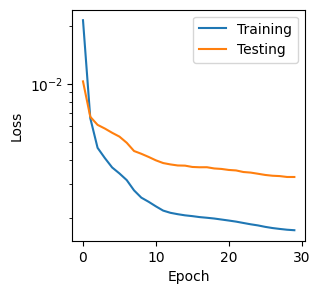

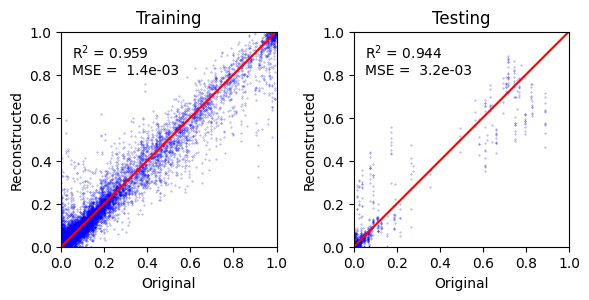

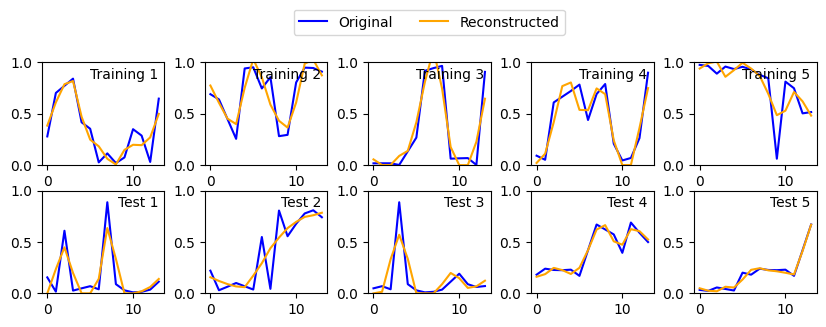

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset

# Plotting the loss values
plt.figure(figsize=(3, 3))
plt.semilogy(train_losses, label='Training')
plt.semilogy(test_losses, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#rank both train and test data for visualization
train_data=torch.Tensor(X_train)
sums = train_data.var(dim=(1,2))  # Shape: (B,)
ranked_indices_train = torch.argsort(sums,descending=True)  # Sort by total sum


test_data=torch.Tensor(X_test)
sums = test_data.var(dim=(1,2))  # Shape: (B,)
ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum


with torch.no_grad():
    output_train, _, _, _ = model(train_data.to(device))
    output_test, _, _, _ = model(test_data.to(device))

# Squeeze the output to match the original data dimension
train_data = train_data
test_data = test_data
output_train = output_train
output_test = output_test

output_train = output_train.cpu().numpy()
output_test = output_test.cpu().numpy()

# Percentage of data to visualize
percentage = 0.2
num_train_samples = int(len(train_data) * percentage)
num_test_samples = int(len(test_data) * percentage)

# Index into the data tensors
subset_train_data = train_data[:num_train_samples]
subset_test_data = test_data[:num_test_samples]

subset_train_pred = output_train[:num_train_samples]
subset_test_pred = output_test[:num_test_samples]

# Plotting the reconstructed data against the original data
fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# Training data plot
axs[0].scatter(subset_train_data.flatten(), subset_train_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[0].plot([0,1], [0,1], 'r')  # y=x line
axs[0].set_xlim([0,1])
axs[0].set_ylim([0,1])
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_xlabel('Original')
axs[0].set_ylabel('Reconstructed')
axs[0].set_title('Training')

r2_train = r2_score(train_data.flatten(), output_train.flatten())
mse_train = np.square(train_data-output_train).mean()
axs[0].text(0.05, 0.95, f'R$^2$ = {r2_train:.3f}\nMSE = {mse_train: .1e}', transform=axs[0].transAxes, verticalalignment='top')

# Testing data plot
axs[1].scatter(subset_test_data.flatten(), subset_test_pred.flatten(), s=0.1, color='blue', alpha=0.5)
axs[1].plot([0,1], [0,1], 'r')  # y=x line
axs[1].set_xlim([0,1])
axs[1].set_ylim([0,1])
axs[1].set_aspect('equal', adjustable='box')
axs[1].set_xlabel('Original')
axs[1].set_ylabel('Reconstructed')
axs[1].set_title('Testing')

r2_test = r2_score(test_data.flatten(), output_test.flatten())
mse_test = np.square(test_data-output_test).mean()
axs[1].text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}', transform=axs[1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()

# Additional Panels for Sample Data Trajectories
fig, axs = plt.subplots(2, 5, figsize=(10, 3))

# Training data trajectories
idx_show = np.random.choice(ranked_indices_train[0:400],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[0, i].plot(train_data[idx,j], color='blue')
        axs[0, i].plot(output_train[idx,j], color='orange')
    axs[0, i].text(x=0.95,y=0.95,s=f'Training {i + 1}',ha="right",va="top",transform=axs[0,i].transAxes)
    axs[0, i].set_ylim([0,1])
axs[0,2].plot([], label='Original', color='blue')
axs[0,2].plot([], label='Reconstructed', color='orange')
axs[0,2].legend(loc="lower center",bbox_to_anchor=(0.5,1.2),ncol=2)
# Testing data trajectories
idx_show = np.random.choice(ranked_indices_test[0:100],5,replace=False)
for i,idx in enumerate(idx_show):
    for j in range(n_target):
        axs[1, i].plot(test_data[idx,j], color='blue')
        axs[1, i].plot(output_test[idx,j], color='orange')
    axs[1, i].text(x=0.95,y=0.95,s=f'Test {i + 1}',ha="right",va="top",transform=axs[1,i].transAxes)
    axs[1, i].set_ylim([0,1])

plt.subplots_adjust(hspace=0.25,wspace=0.33)
plt.show()


# Visualize the training outcome

## visualize the reconstruction as a sanity check

In [8]:
def visualize(axes,n_target,n_embedding,n_show,X_test,test_idx,trial):
    model = VAE(n_target,n_embedding)
    model.load_state_dict(torch.load("./vae_models_CV/T%i_E%i_S%i_trial%i.pth"%
           (n_target,n_embedding,test_idx,trial),weights_only=True))
    model.to("cuda:0");
    model.eval()

    test_data=X_test*1
    sums = test_data.sum(dim=(1,2))  # Shape: (B,)
    ranked_indices_test = torch.argsort(sums,descending=True)  # Sort by total sum
    with torch.no_grad():
        output_test, _, _, _ = model(test_data.to(device))

    # Squeeze the output to match the original data dimension
    output_test = output_test.cpu().numpy()
    
    # Testing data trajectories
    np.random.seed(42)
    idx_show = np.random.choice(ranked_indices_test[0:200],n_show,replace=False)
    for i,idx in enumerate(idx_show):
        ax=axes[i]
        for j in range(n_target):
            ax.plot(test_data[idx,j,:], label='Original', color='blue')
            ax.plot(output_test[idx,j,:], label='Reconstructed', color='orange')
        ax.set_ylim([0,1])
        if i==0:
            ax.text(x=0.95,y=0.95,s=f'latent dim: {n_embedding}',ha="right",va="top",transform=ax.transAxes)
        ax.set_xticks([])
        ax.set_yticks([])
    
    ax=axes[-1]
    # Testing data plot
    ax.scatter(test_data[:400,:,:].flatten(), output_test[:400,:].flatten(), s=0.1, color='blue', alpha=0.5)
    ax.plot([0,1], [0,1], 'r')  # y=x line
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_aspect('equal', adjustable='box')
    r2_test = r2_score(test_data.flatten(), output_test.flatten())
    mse_test = np.square(test_data-output_test).mean()
    ax.text(0.05, 0.95, f'R$^2$ = {r2_test:.3f}\nMSE = {mse_test: .1e}', transform=ax.transAxes, verticalalignment='top')

(14463, 1, 14) (463, 1, 14)


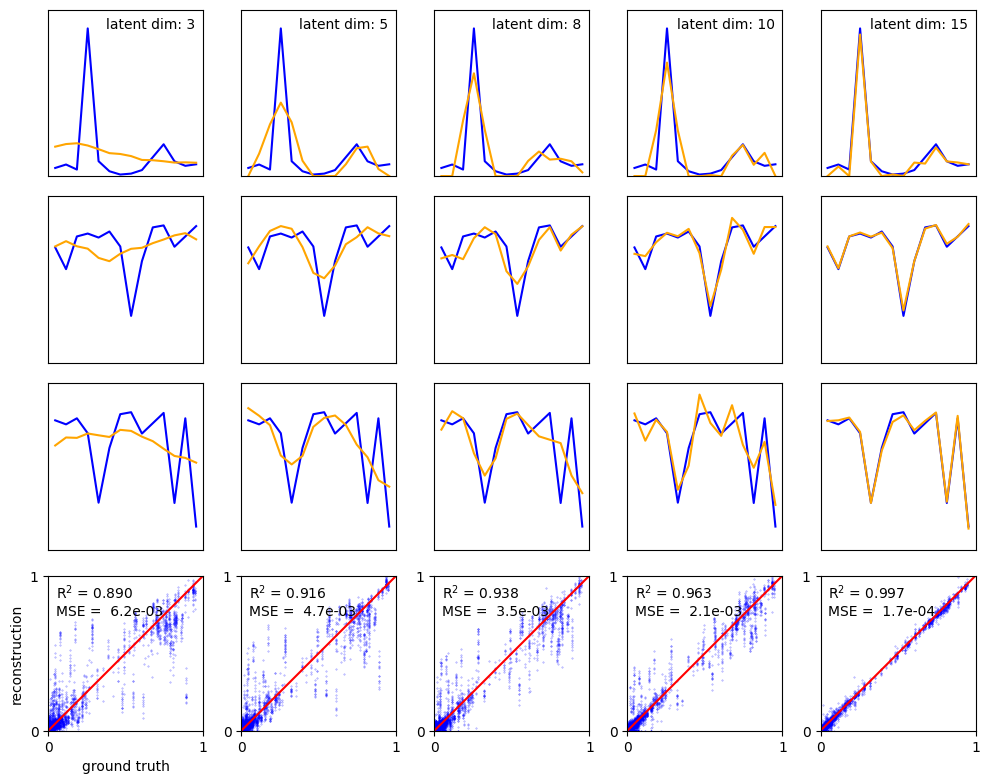

In [9]:
n_target = 1
test_idx = 5
trial = 1
X_train, X_test = get_data(n_target,test_idx)
print(X_train.shape,X_test.shape)
X_test = torch.Tensor(X_test).float()
N_EBD=[3,5,8,10,15]
n_show = 3
fig,axes = plt.subplots(n_show+1,len(N_EBD),figsize=(2*len(N_EBD),2*(n_show+1)))
for i, n_embedding in enumerate(N_EBD):
    visualize(axes[:,i],n_target,n_embedding,n_show,X_test,test_idx,trial)
    ax0=axes[0,i]
ax=axes[-1,0]
ax.set_xlabel("ground truth")
ax.set_ylabel("reconstruction")
fig.tight_layout()

# Get the FUV - embedding relationship

**to calculate the FUV, code below this point requires downloading the entire dataset from Zenodo; but statistical analysis can be performed with `vaginal_embedding_FUV_CV` folder.**

In [15]:
NT = [1,2,3,4,5]
N_EBD=[1,2,3,4,5,6,8,10,12,15,20,30,40]
for i,n_target in enumerate(NT):
    R2_train = np.zeros((24*3,len(N_EBD)))
    R2_test = np.zeros((24*3,len(N_EBD)))
    for j in range(24):
        test_idx = j+1
        X_train, X_test = get_data(n_target,test_idx)
        X_train = torch.Tensor(X_train).float()
        X_test = torch.Tensor(X_test).float()
        for k,n_embedding in enumerate(N_EBD):
            for trial in range(3):
                model = VAE(n_target,n_embedding)
                model.load_state_dict(torch.load("./vae_models_CV/T%i_E%i_S%i_trial%i.pth"%(n_target,n_embedding,test_idx,trial+1),
                                                 weights_only=True))
                model.to("cuda:0");
                model.eval()
                with torch.no_grad():
                    reconstruction_train,_,_,_ = model(X_train.to("cuda:0"))
                    reconstruction_train = reconstruction_train.cpu()
                    mse_train = F.mse_loss(X_train,reconstruction_train)
                    r2_train = r2_score(X_train.flatten(), reconstruction_train.flatten())
                    R2_train[3*j+trial,k]=r2_train

                    reconstruction_test,_,_,_ = model(X_test.to("cuda:0"))
                    reconstruction_test = reconstruction_test.cpu()
                    mse_test = F.mse_loss(X_test,reconstruction_test)
                    r2_test = r2_score(X_test.flatten(), reconstruction_test.flatten())

                    R2_test[3*j+trial,k]=r2_test
    R2_train = np.array(R2_train)
    R2_test = np.array(R2_test)
    FUV_train = (1-R2_train)*100
    FUV_test = (1-R2_test)*100
    data_train = np.vstack([N_EBD,FUV_train])
    np.savetxt("./vaginal_embedding_FUV_CV/T%i_train.txt"%(n_target),data_train)
    data_test = np.vstack([N_EBD,FUV_test])
    np.savetxt("./vaginal_embedding_FUV_CV/T%i_test.txt"%(n_target),data_test)
    print(f"{n_target}-target finished")

1-target finished
2-target finished
3-target finished
4-target finished
5-target finished


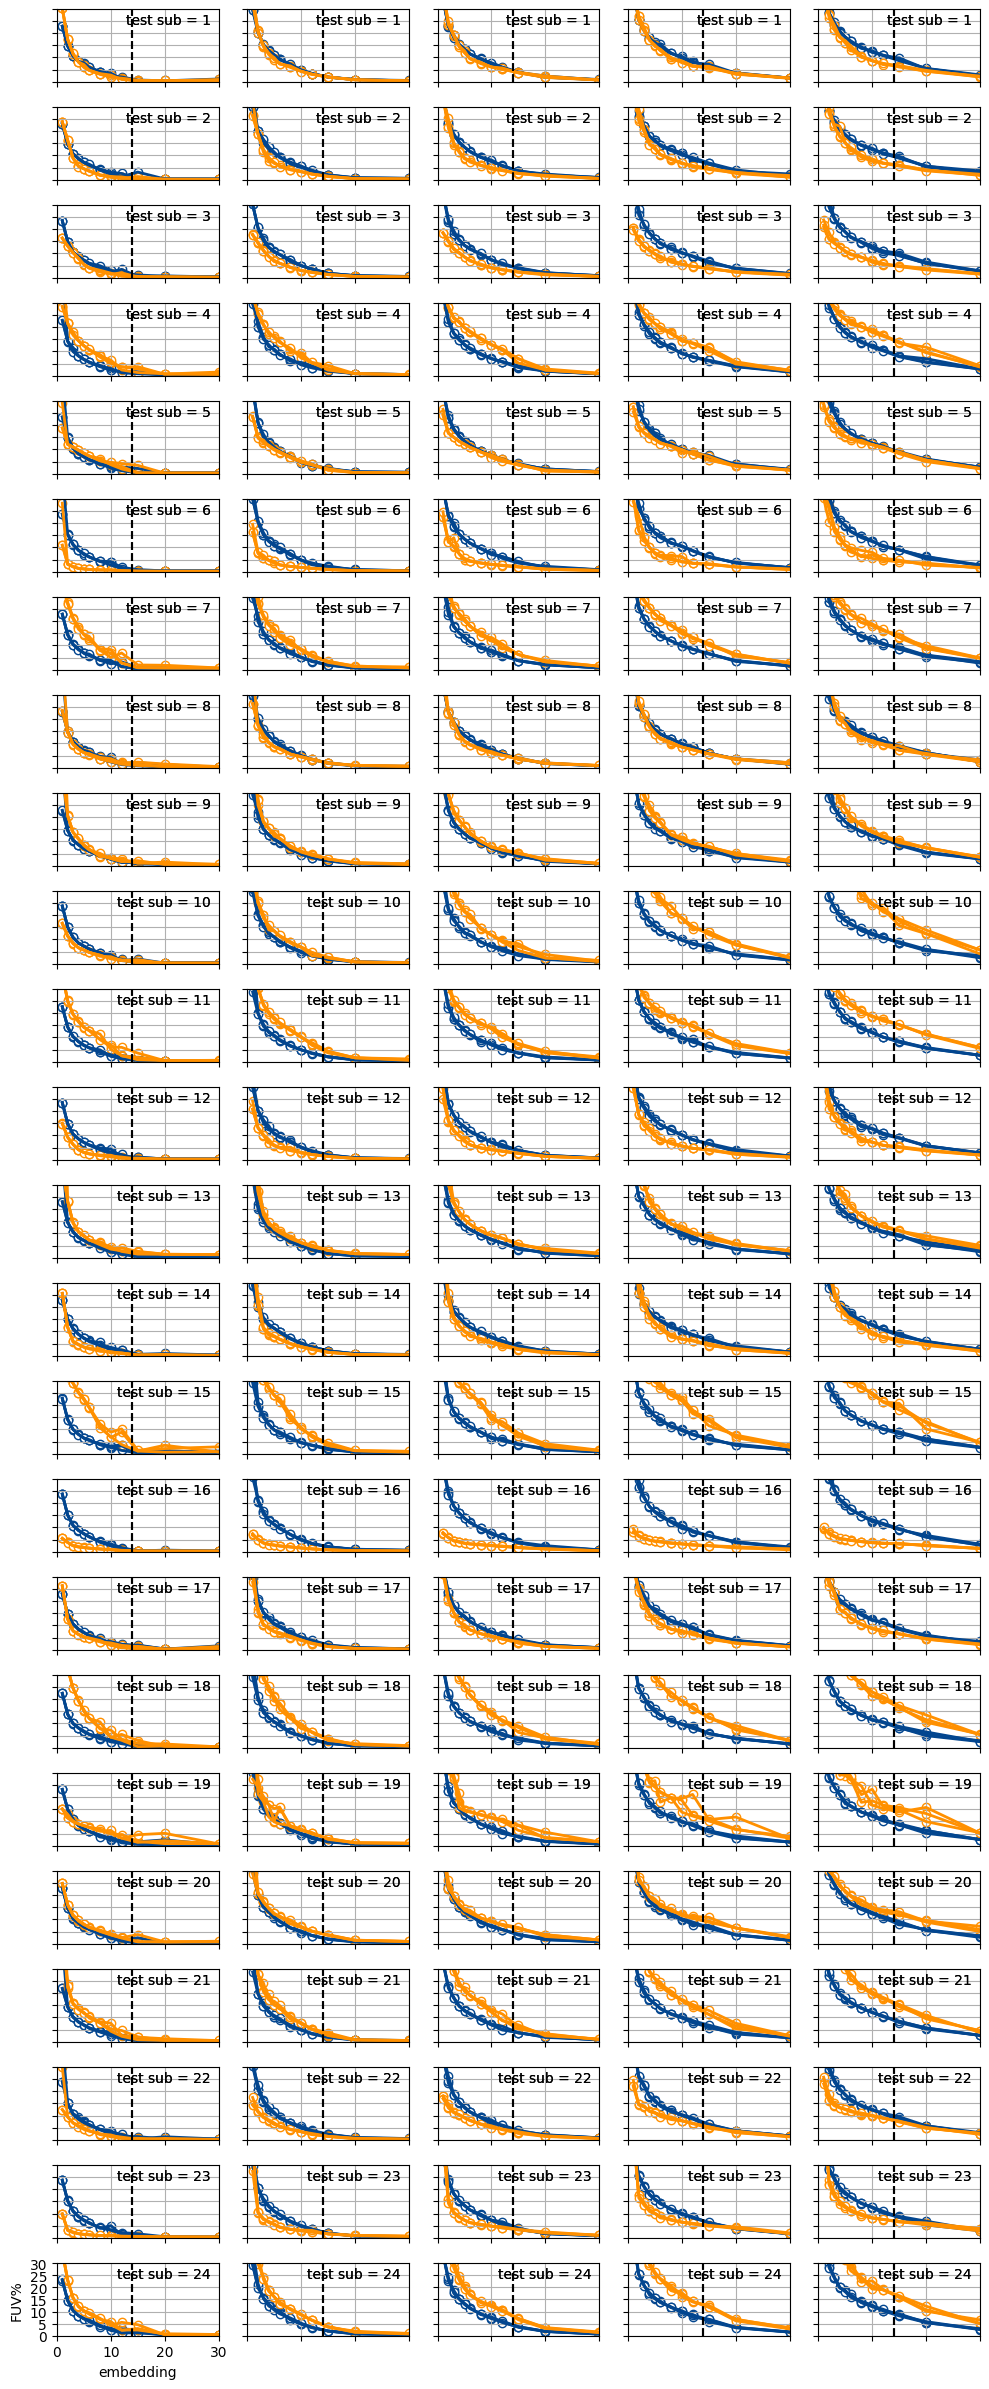

In [5]:
colors = ['#03468F', '#FF9000','#00A400','#FF9797','#808080',]
fig,axes = plt.subplots(24,5,figsize=(10,24))
N_TG = [1,2,3,4,5]
for i in range(len(N_TG)):
    n_target=N_TG[i]
    for s in ["train","test"]:
        data=np.loadtxt("./vaginal_embedding_FUV_CV/T%i_%s.txt"%(n_target,s))
        N_EBD=data[0,:]
        FUV = data[1:,:]
        n_reps = 24
        for j in range(n_reps):
            ax = axes[j,i]
            fuv = FUV[3*j:3*(j+1),:]
            for k in range(3):
                c = colors[0] if s=="train" else colors[1]
                ax.plot(N_EBD,fuv[k],color=c,lw=2)
                ax.scatter(N_EBD,fuv[k],ec=c,fc="w")
            ax.plot([14,14],[0,30],c="k",ls="--")
            ax.text(x=0.95,y=0.95,s=f"test sub = {j+1}",ha="right",va="top",transform=ax.transAxes)
            ax.set_yticks(np.arange(0,40,5))
            ax.set_xticks(np.arange(0,41,10))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_ylim([0,30])
            ax.set_xlim([0,30])
            ax.grid(True)
axes[-1,0].set_xlabel("embedding")
axes[-1,0].set_ylabel("FUV%")
axes[-1,0].set_yticklabels(np.arange(0,40,5))
axes[-1,0].set_xticklabels(np.arange(0,41,10))
fig.tight_layout()
#fig.savefig(f"./figures/{sample}_CV.png",dpi=300)

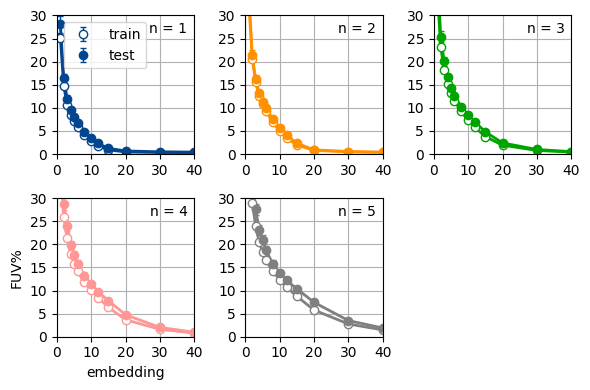

In [11]:
colors = ['#03468F', '#FF9000','#00A400','#FF9797','#808080',]
fig,axes1 = plt.subplots(2,3,figsize=(6,4))
axes1=axes1.flat
N_TG = [1,2,3,4,5]
for i in range(len(N_TG)):
    ax1 = axes1[i]
    n_target=N_TG[i]
    for s in ["train","test"]:
        data=np.loadtxt("./vaginal_embedding_FUV_CV/T%i_%s.txt"%(n_target,s))
        N_EBD=data[0,:]
        FUV = data[1:,:]
        n_reps = FUV.shape[0]
        mean_FUV=np.mean(FUV,axis=0)
        std_FUV = np.std(FUV,axis=0,ddof=1)
        se_FUV = std_FUV/np.sqrt(n_reps)
        if s=="train":
            ax1.errorbar(N_EBD,mean_FUV,se_FUV,marker="o",c=colors[i],mfc="w",capsize=2,label=s,lw=0,
                        elinewidth=1)
        else:
            ax1.errorbar(N_EBD,mean_FUV,se_FUV,marker="o",c=colors[i],mfc=colors[i],capsize=2,label=s,lw=0,
                        elinewidth=1)
        ax1.plot(N_EBD,mean_FUV,color=colors[i],lw=2)

    ax1.text(x=0.95,y=0.95,s=f"n = {n_target}",ha="right",va="top",transform=ax1.transAxes)
    ax1.set_yticks(np.arange(0,40,5))
    ax1.set_xticks(np.arange(0,41,10))
    ax1.set_ylim([0,30])
    ax1.set_xlim([0,40])
    ax1.grid(True)
axes1[3].set_xlabel("embedding")
axes1[3].set_ylabel("FUV%")
axes1[-1].set_visible(False)
axes1[0].legend()
fig.tight_layout()
#fig.savefig(f"./figures/train_test_check.png",dpi=300)

# Estimate the critical dimension for different number of observables, by determining the Ec that gives FUV = 5% / 8% / 10%

**statistical analysis beyond this point can be performed with `vaginal_embedding_FUV_CV` folder.**

1-target Estimated Ec for FUV ≤ 5%: 7.8 95% CI: [7.18, 8.53]
2-target Estimated Ec for FUV ≤ 5%: 10.8 95% CI: [10.02, 11.22]
3-target Estimated Ec for FUV ≤ 5%: 14.7 95% CI: [14.11, 15.52]
4-target Estimated Ec for FUV ≤ 5%: 19.6 95% CI: [18.94, 20.86]
5-target Estimated Ec for FUV ≤ 5%: 26.2 95% CI: [25.15, 27.07]


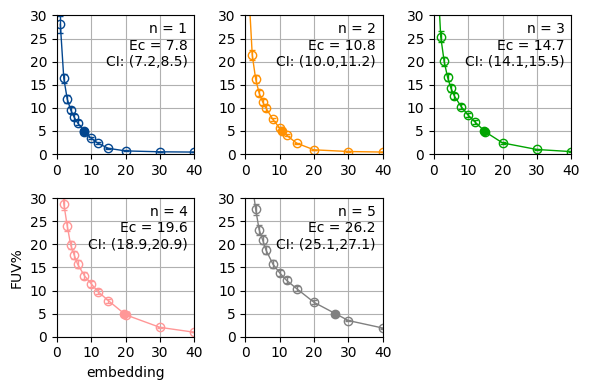

In [13]:
import numpy as np
from scipy.interpolate import interp1d
from sklearn.utils import resample

# Inputs:
# N_EBD: shape (13,)
# FUV: shape (5, 13) — each column corresponds to one x
# y_target: the threshold y value

y_target = 5 # us FUV = 10% as the threshold value to determine Ec

colors = ['#03468F', '#FF9000','#00A400','#FF9797','#808080',]
fig,axes = plt.subplots(2,3,figsize=(6,4))
axes = axes.flat

N_TG = [1,2,3,4,5]
bootstrap_Ec = np.zeros((4,5))
bootstrap_Ec[0,:] = N_TG

for i,n_target in enumerate(N_TG):

    ax1 = axes[i]
    data=np.loadtxt("./vaginal_embedding_FUV_CV/T%i_test.txt"%(n_target))
    N_EBD = data[0,:]
    FUV = data[1:,:]
    
    # Step 1: Compute mean y for each x (across replicates)
    mean_FUV = FUV.mean(axis=0)  # shape (5,)
    std_FUV = np.std(FUV,axis=0,ddof=1)
    n_reps = FUV.shape[0]
    se_FUV = std_FUV/np.sqrt(n_reps)
    ax1.errorbar(N_EBD,mean_FUV,se_FUV,marker="o",c=colors[i],mfc="None",capsize=2,lw=0,elinewidth=1)
    ax1.plot(N_EBD,mean_FUV,c=colors[i],lw=1)
    
    # Step 2: Interpolation
    interp_func = interp1d(mean_FUV[::-1], N_EBD[::-1], bounds_error=False, fill_value="extrapolate")
    Ec_est = interp_func(y_target)
    bootstrap_Ec[1,i]=Ec_est

    # Step 3: Bootstrap to estimate uncertainty
    n_bootstraps = 1000
    Ec_boots = []

    for _ in range(n_bootstraps):
        # Resample along the replicate axis for each n_ebd (i.e., column-wise)
        boot_FUV = np.array([resample(FUV[:, j]) for j in range(FUV.shape[1])]).T  # shape still (5, 12)
        boot_mean_FUV = boot_FUV.mean(axis=0)  # shape (5,)

        # Interpolate this bootstrapped curve
        boot_interp = interp1d(boot_mean_FUV[::-1], N_EBD[::-1], bounds_error=False, fill_value="extrapolate")
        Ec_boots.append(boot_interp(y_target))

    Ec_boots = np.array(Ec_boots)
    Ec_ci_lower, Ec_ci_upper = np.percentile(Ec_boots, [2.5, 97.5])
    bootstrap_Ec[2,i]=Ec_ci_lower
    bootstrap_Ec[3,i]=Ec_ci_upper

    print(f"{n_target}-target Estimated Ec for FUV ≤ {y_target}%: {Ec_est:.1f} 95% CI: [{Ec_ci_lower:.2f}, {Ec_ci_upper:.2f}]")
    xerr = np.array([[Ec_ci_lower],[Ec_ci_upper]])-Ec_est
    ax1.errorbar(Ec_est,y_target,xerr=np.abs(xerr),yerr=None,marker="o",c=colors[i],capsize=2,lw=0,
            elinewidth=1)

    ax1.text(x=0.95,y=0.95,s=f"n = {n_target}\nEc = {Ec_est:.1f}\nCI: ({Ec_ci_lower:.1f},{Ec_ci_upper:.1f})",
             ha="right",va="top",transform=ax1.transAxes)
    ax1.set_yticks(np.arange(0,40,5))
    ax1.set_xticks(np.arange(0,41,10))
    ax1.set_ylim([0,30])
    ax1.set_xlim([0,40])
    ax1.grid(True)
np.savetxt(f"./vaginal_embedding_FUV_CV/Ec_data_FUV={y_target}.txt",bootstrap_Ec)
axes[3].set_xlabel("embedding")
axes[3].set_ylabel("FUV%")
axes[-1].set_visible(False)
fig.tight_layout()

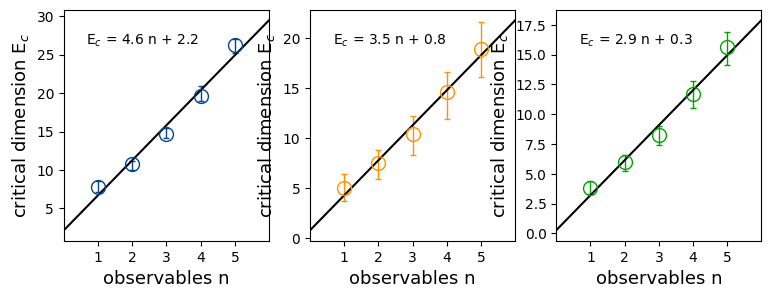

In [15]:
colors1 = ['#03468F', '#FF9000', '#00A400', '#FF9797', '#808080',]
fig,axes = plt.subplots(1,3,figsize=(9,3))
Y_TARGET = [5, 8, 10]
for i, y_target in enumerate(Y_TARGET):
    ax=axes[i]
    data = np.loadtxt(f"./vaginal_embedding_FUV_CV/Ec_data_FUV={y_target}.txt")
    N_TG = data[0,:]
    Ec = data[1,:]
    ci_lower = data[2,:]
    ci_upper = data[3,:]
    yerr = [Ec-ci_lower,ci_upper-Ec]
    ax.errorbar(N_TG,Ec,yerr,marker="o",c=colors[i],mfc="None",capsize=2,lw=0,markersize=10,
                    elinewidth=1)
    z = np.polyfit(N_TG, Ec, 1)
    p = np.poly1d(z)
    x = np.linspace(0, 6, 20)
    y = p(x)
    ax.plot(x, y, linewidth=1.5, c="k")
    ax.set_xticks([1,2,3,4,5])
    ax.set_xlim([0, 6])
    if z[1] < 0:
        txt = "E$_c$ = %1.1f n - %1.1f" % (z[0], -z[1])
    else:
        txt = "E$_c$ = %1.1f n + %1.1f" % (z[0], z[1])
    ax.text(x=0.11,y=0.85,s=txt,transform=ax.transAxes, fontsize=10)
    ax.set_xlabel("observables n", fontsize=13)
    ax.set_ylabel("critical dimension E$_c$", fontsize=13)

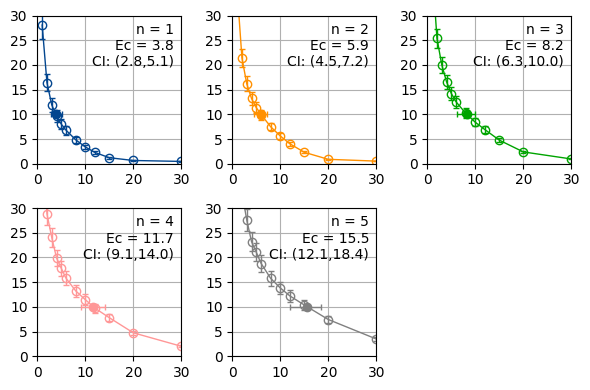

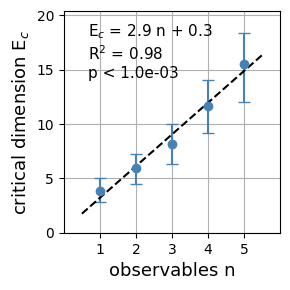

In [16]:
from scipy.interpolate import interp1d
from sklearn.utils import resample
from sklearn.metrics import r2_score

# Parameters
y_target  = 10
n_boot = 1000
colors = ['#03468F', '#FF9000', '#00A400', '#FF9797', '#808080']
N_TG = np.arange(1,6,1)

fig, axes = plt.subplots(2, 3, figsize=(6, 4))
axes = axes.flat
fig2, ax2 = plt.subplots(1,1, figsize=(3,3))
bootstrap_Ec = np.zeros((4, 5))
bootstrap_Ec[0, :] = N_TG
Ec_boot_matrix = np.zeros((n_boot, len(N_TG)))

for i, n_target in enumerate(N_TG):
    ax1 = axes[i]
    data = np.loadtxt("./vaginal_embedding_FUV_CV/T%i_test.txt"%(n_target))
    N_EBD = data[0, :]
    FUV = data[1:, :]

    FUV_reshaped = []
    for k in range(24):
        FUV_reshaped.append(FUV[3*k:3*(k+1),:])
    FUV_reshaped = np.array(FUV_reshaped)

    FUV = np.mean(FUV_reshaped,axis=1)# FUV across 24-fold cross validation, each averaged across 3 replicates of VAEs

    # Step 1: Plot mean FUV
    mean_FUV = FUV.mean(axis=0)
    std_FUV = np.std(FUV, axis=0, ddof=1)
    se_FUV = std_FUV / np.sqrt(FUV.shape[0])
    ax1.errorbar(N_EBD, mean_FUV, se_FUV, marker="o", c=colors[i], mfc="None", capsize=2, lw=0, elinewidth=1)
    ax1.plot(N_EBD, mean_FUV, c=colors[i], lw=1)

    # Step 2: Bootstrap Ec
    Ec_boots = []
    for _ in range(n_boot):
        fold_indices = np.random.choice(24, size=24, replace=True)
        boot_FUV = FUV[fold_indices]        # shape (24, 10)
        boot_mean_FUV = boot_FUV.mean(axis=0)  # shape (10,)
        boot_interp = interp1d(boot_mean_FUV[::-1], N_EBD[::-1], bounds_error=False, fill_value="extrapolate")
        Ec_boots.append(boot_interp(y_target))
    Ec_boots = np.array(Ec_boots)
    Ec_boot_matrix[:, i] = Ec_boots
    Ec_ci_lower, Ec_ci_upper = np.percentile(Ec_boots, [2.5, 97.5])
    Ec_mean = np.mean(Ec_boots)
    bootstrap_Ec[1, i] = Ec_mean
    bootstrap_Ec[2, i] = Ec_ci_lower
    bootstrap_Ec[3, i] = Ec_ci_upper

    # Plot Ec point
    ax1.errorbar(Ec_mean, y_target, xerr=[[Ec_mean - Ec_ci_lower], [Ec_ci_upper - Ec_mean]], yerr=None,
                 marker="o", c=colors[i], capsize=2, lw=0, elinewidth=1)
    ax1.text(0.95, 0.95, f"n = {n_target}\nEc = {Ec_mean:.1f}\nCI: ({Ec_ci_lower:.1f},{Ec_ci_upper:.1f})",
             ha="right", va="top", transform=ax1.transAxes)
    ax1.set_yticks(np.arange(0, 40, 5))
    ax1.set_xticks(np.arange(0, 31, 10))
    ax1.set_ylim([0, 30])
    ax1.set_xlim([0, 30])
    ax1.grid(True)
axes[-1].set_visible(False)

# Linear regression on bootstrapped Ec values
slopes, intercepts = [], []
for b in range(n_boot):
    slope, intercept = np.polyfit(N_TG, Ec_boot_matrix[b], 1)
    slopes.append(slope)
    intercepts.append(intercept)
slopes = np.array(slopes)
intercepts = np.array(intercepts)
slope_ci = np.percentile(slopes, [2.5, 97.5])
intercept_ci = np.percentile(intercepts, [2.5, 97.5])

# Plot Ec vs n_target with regression

Ec_mean = Ec_boot_matrix.mean(axis=0)
bootstrap_Ec[1, :] = Ec_mean
Ec_lower = np.percentile(Ec_boot_matrix, 2.5, axis=0)
Ec_upper = np.percentile(Ec_boot_matrix, 97.5, axis=0)
ax2.errorbar(N_TG, Ec_mean, yerr=[Ec_mean - Ec_lower, Ec_upper - Ec_mean],
            fmt='o', color='steelblue', capsize=4)

x_fit = np.linspace(min(N_TG)-0.5, max(N_TG)+0.5, 100)
y_fit = slopes.mean() * x_fit + intercepts.mean()
ax2.plot(x_fit, y_fit, 'k--')

y_fit2 = slopes.mean() * N_TG + intercepts.mean()
R2 = r2_score(Ec_mean,y_fit2)
p = 2 * min(np.mean(slopes <= 0), np.mean(slopes >= 0))

txt = (f"E$_c$ = {slopes.mean():.1f} n {'+' if intercepts.mean() >= 0 else '-'} {abs(intercepts.mean()):.1f}\n"
        f"R$^2$ = {R2:.2f}\n"
        f"p {'<' if p<1/n_boot else '='} {max([p,1/n_boot]):.1e}")
ax2.text(x=0.11, y=0.7, s=txt, transform=ax2.transAxes, fontsize=11)
ax2.set_xticks([1,2,3,4,5])
ax2.set_xlim([0, 6])
ax2.set_ylim([0, max(Ec_upper) + 2])
ax2.grid(True)

# Final axis labels
ax2.set_xlabel("observables n", fontsize=13)
ax2.set_ylabel("critical dimension E$_c$", fontsize=13)

np.savetxt(f"./vaginal_embedding_FUV_CV/Ec_data_FUV={y_target}.txt", bootstrap_Ec)
np.savetxt(f"./vaginal_embedding_FUV_CV/Ec_data_FUV={y_target}_bootstrap.txt", Ec_boot_matrix)

fig.tight_layout()
fig2.tight_layout()